In [1]:
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

_TA = "TMT-A"
_TB = "TMT-B"
_N = "Neutral"
_T = "top-down"
_B = "bottom-up"
_S = "spatial"

DISCARD_SET = {0}
PARTICIPANTS = list(set(list(range(1, 20))) - DISCARD_SET)


def group_by_acs(df, threshold=None):
    """
    Given a  dataframe with a column "ACS", depending on the given threshold split them into two groups and change the column to "Good" and "Poor". If threshold is None, use the median of the ACS column.
    """
    copy_df = df.copy()
    if threshold is None:
        threshold = df["ACS"].median()
    copy_df["ACS"] = df["ACS"].apply(lambda x: "Good" if x < threshold else "Poor")
    print(f"Threshold for ACS: {threshold}")
    return copy_df


def test_attr(df, attr, attr_values, metric, test_type='between', group=None):
    query1 = f'{attr} == "{attr_values[0]}"'
    query2 = f'{attr} == "{attr_values[1]}"'
    if group is not None:
        query1 += f' and {group[0]} == "{group[1]}"'
        query2 += f' and {group[0]} == "{group[1]}"'

    mean1 = df.query(query1)[metric].mean()
    mean2 = df.query(query2)[metric].mean()
    print(f"Mean for Query 1: {mean1:.3f}")
    print(f"Mean for Query 2: {mean2:.3f}")
    # res = pg.mwu(df.query(query1)[metric], df.query(query2)[metric])
    # Remove outliers using IQR method

    def filter_outliers_and_test(data1, data2, paired=False):
        """
        Filter outliers using IQR method and perform t-test
        
        Parameters:
        -----------
        data1 : pandas Series
            First data group
        data2 : pandas Series
            Second data group
        paired : bool, default=False
            Whether to perform paired t-test
            
        Returns:
        --------
        res : pandas DataFrame
            t-test result
        """
        # Calculate IQR for both groups
        Q1_1, Q3_1 = data1.quantile(0.25), data1.quantile(0.75)
        IQR_1 = Q3_1 - Q1_1
        Q1_2, Q3_2 = data2.quantile(0.25), data2.quantile(0.75)
        IQR_2 = Q3_2 - Q1_2
        
        # Filter outliers
        filtered_data1 = data1[(data1 >= Q1_1 - 1.5 * IQR_1) & (data1 <= Q3_1 + 1.5 * IQR_1)]
        filtered_data2 = data2[(data2 >= Q1_2 - 1.5 * IQR_2) & (data2 <= Q3_2 + 1.5 * IQR_2)]
        print("type 1 count: ", len(filtered_data1))
        print("type 2 count: ", len(filtered_data2))
        
        # Perform t-test on filtered data
        return pg.ttest(filtered_data1, filtered_data2, paired=paired)

    data1 = df.query(query1)[metric]
    data2 = df.query(query2)[metric]
    normality1 = pg.normality(data1)
    normality2 = pg.normality(data2)
    
    if test_type == 'between':
        if normality1['normal'][0] and normality2['normal'][0]:
            print("Normality test passed.")
            res = filter_outliers_and_test(data1, data2, paired=False)
        else:
            res = pg.mwu(df.query(query1)[metric], df.query(query2)[metric])
    elif test_type == 'within':
        if normality1['normal'][0] and normality2['normal'][0]:
            print("Normality test passed.")
            res = filter_outliers_and_test(data1, data2, paired=True)
        else:
            res = pg.mwu(df.query(query1)[metric], df.query(query2)[metric])
    print(res)
    
    if res['p-val'].values[0] < 0.05:
        print(f"Significant detected!")
    else:
        print(f"No significant difference detected.")

def test_attr_corr(df, attr, metric, trial_type=_T):
    data1 = df[df["Trial_Type"] == trial_type][attr]
    data2 = df[df["Trial_Type"] == trial_type][metric]
    print(f"Correlation between {attr} and {metric} for {trial_type}:")
    res = pg.corr(data1, data2)
    print(res)


ALL_RESULT_DF_NUM = pd.read_csv("results/artmt/artmt_gaze_metrics.csv")
print(ALL_RESULT_DF_NUM)
ALL_RESULT_DF = group_by_acs(ALL_RESULT_DF_NUM)



     UserID   ACS Trial_Type  MotorSkill  CompletionTime  DistractorHits  \
0         1  40.0    Neutral    1.091114       69.631836               0   
1         1  40.0      TMT-A    1.091114       87.116580               0   
2         1  40.0      TMT-B    1.091114      268.215500               0   
3         1  40.0  bottom-up    1.091114       55.675660               0   
4         1  40.0    spatial    1.091114      139.242920               0   
..      ...   ...        ...         ...             ...             ...   
109      19  34.0      TMT-A    1.017446       66.900420               0   
110      19  34.0      TMT-B    1.017446      194.013153               0   
111      19  34.0  bottom-up    1.017446       67.261720               0   
112      19  34.0    spatial    1.017446      132.479000               0   
113      19  34.0   top-down    1.017446      114.345520               1   

     MissHits  WrongHits       MFD        FR       PFT         MSV  \
0           5    

In [35]:
# test for MFD in TMT-A and TMT-B

test_attr(ALL_RESULT_DF, attr="Trial_Type", attr_values=[_TA, _B], metric="MSV", test_type='within')

Mean for Query 1: 142.617
Mean for Query 2: 136.977
Normality test passed.
type 1 count:  19
type 2 count:  19
               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test  1.891056   18   two-sided  0.074823  [-0.63, 11.9]  0.450568  1.037   

           power  
T-test  0.459847  
No significant difference detected.


In [19]:
for trial_type in [_TA, _TB, _T, _B, _S]:
    print(f"Testing for {trial_type} trial type")
    test_attr(ALL_RESULT_DF, attr="ACS", attr_values=["Good", "Poor"], metric="MFD", test_type='between', group=("Trial_Type", trial_type))

Testing for TMT-A trial type
Mean for Query 1: 0.212
Mean for Query 2: 0.210
Normality test passed.
type 1 count:  8
type 2 count:  11
               T        dof alternative     p-val          CI95%   cohen-d  \
T-test  0.093676  16.153485   two-sided  0.926518  [-0.02, 0.03]  0.042736   

         BF10     power  
T-test  0.409  0.050865  
No significant difference detected.
Testing for TMT-B trial type
Mean for Query 1: 0.211
Mean for Query 2: 0.210
Normality test passed.
type 1 count:  7
type 2 count:  11
               T       dof alternative     p-val          CI95%   cohen-d  \
T-test -0.938158  11.71571   two-sided  0.367102  [-0.03, 0.01]  0.466923   

         BF10    power  
T-test  0.564  0.14863  
No significant difference detected.
Testing for top-down trial type
Mean for Query 1: 0.192
Mean for Query 2: 0.187
Normality test passed.
type 1 count:  8
type 2 count:  11
               T        dof alternative     p-val          CI95%   cohen-d  \
T-test  0.595334  11.881612 

In [20]:
for trial_type in [_TA, _TB, _T, _B, _S]:
    print(f"Testing for {trial_type} trial type")
    test_attr_corr(ALL_RESULT_DF_NUM, attr="ACS", metric="MFD", trial_type=trial_type)

Testing for TMT-A trial type
Correlation between ACS and MFD for TMT-A:
          n         r          CI95%     p-val   BF10     power
pearson  19 -0.292646  [-0.66, 0.19]  0.224041  0.566  0.233896
Testing for TMT-B trial type
Correlation between ACS and MFD for TMT-B:
          n        r          CI95%     p-val   BF10     power
pearson  19 -0.41255  [-0.73, 0.05]  0.079201  1.194  0.434134
Testing for top-down trial type
Correlation between ACS and MFD for top-down:
          n         r           CI95%     p-val   BF10     power
pearson  19 -0.523771  [-0.79, -0.09]  0.021353  3.344  0.661908
Testing for bottom-up trial type
Correlation between ACS and MFD for bottom-up:
          n         r          CI95%     p-val   BF10     power
pearson  19 -0.115983  [-0.54, 0.36]  0.636329  0.315  0.075645
Testing for spatial trial type
Correlation between ACS and MFD for spatial:
          n         r          CI95%     p-val   BF10     power
pearson  19 -0.308788  [-0.67, 0.17]  0.198335

In [60]:
test_attr(ALL_RESULT_DF, attr="Trial_Type", attr_values=[_TA, _T], metric="FR", test_type='within', group=("ACS", "Poor"))

Mean for Query 1: 2.737
Mean for Query 2: 2.920
     U-val alternative     p-val       RBC      CLES
MWU   32.0   two-sided  0.065971  0.471074  0.264463
No significant difference detected.


In [19]:
import os
os.environ["R_HOME"] = "D:\\Coding\\Anaconda\\envs\\sudoku\\Lib\\R"
from pymer4.models import Lmer, Lm

def fit_big_model(attr="MFD"):
    # exclude Trial_Type == "Neutral"
    # df = ALL_RESULT_DF[ALL_RESULT_DF["Trial_Type"] != _N]
    # exclude Trial_Type == "TMT-B" and "Neutral" 
    df = ALL_RESULT_DF_NUM[ALL_RESULT_DF_NUM["Trial_Type"].isin([_TA, _T, _N, _B, _S])]
    # rename TMT-A to A
    df["Trial_Type"] = df["Trial_Type"].replace({_TA: "A", _T: "Top-Down", _B: "Bottom-Up", _S: "Spatial", _N: "Neutral"})
    model = Lmer(f"{attr} ~ Trial_Type * ACS + MotorSkill + (1|UserID)", data=df)
    # model = Lm(f"{attr} ~ Trial_Type * ACS + MotorSkill", data=df)

    # model.fit(factors={"Trial_Type": [_TA, _TB, _B, _S, _T]})

    model.fit()
    print(model.summary())
    # add anova
    # anova = model.anova()
    # print(anova)

fit_big_model("BR")


Linear mixed model fit by REML [’lmerMod’]
Formula: BR~Trial_Type*ACS+MotorSkill+(1|UserID)

Family: gaussian	 Inference: parametric

Number of observations: 95	 Groups: {'UserID': 19.0}

Log-likelihood: 47.822 	 AIC: -69.644

Random effects:

                 Name    Var    Std
UserID    (Intercept)  0.078  0.280
Residual               0.004  0.066

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: BR~Trial_Type*ACS+MotorSkill+(1|UserID)

Family: gaussian	 Inference: parametric

Number of observations: 95	 Groups: {'UserID': 19.0}

Log-likelihood: 47.822 	 AIC: -69.644

Random effects:

                 Name    Var    Std
UserID    (Intercept)  0.078  0.280
Residual               0.004  0.066

No random effect correlations specified

Fixed effects:

                         Estimate  2.5_ci  97.5_ci     SE      DF  T-stat  \
(Intercept)                 0.378  -0.894    1.649  0.649  16.304   0.582   
Trial_TypeBottom-Up       

C:\Users\zhhqu\AppData\Local\Temp\ipykernel_2676\3669164363.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Trial_Type"] = df["Trial_Type"].replace({_TA: "A", _T: "Top-Down", _B: "Bottom-Up", _S: "Spatial", _N: "Neutral"})


In [14]:
def fit_small_model(attr="MFD", trial_type=_TA):
    # exclude Trial_Type == "Neutral"
    # df = ALL_RESULT_DF[ALL_RESULT_DF["Trial_Type"] != _N]
    # exclude Trial_Type == "TMT-B" and "Neutral" 
    df = ALL_RESULT_DF_NUM[ALL_RESULT_DF_NUM["Trial_Type"].isin([trial_type])]
    # rename TMT-A to A
    model = Lm(f"{attr} ~ ACS + MotorSkill", data=df)
    # model.fit(factors={"Trial_Type": [_TA, _TB, _B, _S, _T]})

    model.fit()
    print(model.summary())


fit_small_model("CompletionTime", trial_type=_S)

Formula: CompletionTime~ACS+MotorSkill

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 19	 R^2: 0.053	 R^2_adj: -0.065

Log-likelihood: -83.388 	 AIC: 172.777	 BIC: 175.610

Fixed effects:

Formula: CompletionTime~ACS+MotorSkill

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 19	 R^2: 0.053	 R^2_adj: -0.065

Log-likelihood: -83.388 	 AIC: 172.777	 BIC: 175.610

Fixed effects:

            Estimate  2.5_ci  97.5_ci      SE  DF  T-stat  P-val Sig
Intercept     98.720  -4.735  202.174  48.801  16   2.023  0.060   .
ACS           -0.326  -1.644    0.991   0.622  16  -0.525  0.607    
MotorSkill    22.161 -55.538   99.860  36.652  16   0.605  0.554    


In [ ]:
METRIC = "Before_Recognition"    
ATTR = "RFR"
# upper case of the first letter of all words in METRIC
METRIC_ABBR = "".join([word[0].upper() for word in METRIC.split()])

df_merged_time = pd.read_csv(f"D:\\Research\\I3T\\Projects\\CPR\\CPR_SA\\gaze_extraction\\results\\period_21s/cleaned\\{ATTR}.csv")
df_merged_time = df_merged_time[df_merged_time["UserID"].isin(PARTICIPANTS)]
df_merged_time = df_merged_time[df_merged_time["Incident"] != '-1']
df_merged_time = floor_and_ceiling_of_detection(df_merged_time, 0.5)
df_new = df_merged_time.copy()[["UserID", "Incident", "Detection", METRIC]]
df_new = df_new.rename(columns={METRIC: METRIC_ABBR})

# change "N" to "A", "An" to "B", "AnA" to "C"
import os
os.environ["R_HOME"] = "D:\\Coding\\Anaconda\\envs\\sudoku\\Lib\\R"

from pymer4.models import Lmer, Lm

model = Lmer(f"{METRIC_ABBR} ~ Incident + Detection + (1|UserID)", data=df_new)
model.fit()
print(model.summary())

# model = Lmer(f"{METRIC_ABBR} ~ Incident * Detection + (1|UserID)", data=df_new)
# model.fit(factors={"Incident": ["bleeding", "vomiting"], "Detection": ['0', '1']})
# # print(model.summary())

# anova_table = model.anova()
# anova_table["np2"] = anova_table["SS"] / (anova_table["SS"] + sum(model.residuals ** 2))
# print(anova_table)

Linear mixed model fit by REML [’lmerMod’]
Formula: B~Incident+Detection+(1|UserID)

Family: gaussian	 Inference: parametric

Number of observations: 60	 Groups: {'UserID': 30.0}

Log-likelihood: -28.728 	 AIC: 67.456

Random effects:

                 Name    Var    Std
UserID    (Intercept)  0.046  0.215
Residual               0.098  0.313

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: B~Incident+Detection+(1|UserID)

Family: gaussian	 Inference: parametric

Number of observations: 60	 Groups: {'UserID': 30.0}

Log-likelihood: -28.728 	 AIC: 67.456

Random effects:

                 Name    Var    Std
UserID    (Intercept)  0.046  0.215
Residual               0.098  0.313

No random effect correlations specified

Fixed effects:

                  Estimate  2.5_ci  97.5_ci     SE      DF  T-stat  P-val  Sig
(Intercept)          0.189  -0.007    0.384  0.100  55.191   1.889  0.064    .
Incidentvomiting     0.030  -0.133    

Detection stats for bleeding:
Detection
1    21
0     9
Name: count, dtype: int64
Detection stats for vomiting:
Detection
0    15
1    15
Name: count, dtype: int64
Correlation: -0.266
Mean for Detection 1: 0.607
Mean for Detection 0: 0.908
Normality test for Detection 1:  False
Normality test for Detection 0:  False
     U-val alternative     p-val       RBC      CLES
MWU  314.0   two-sided  0.076185  0.273148  0.363426
No significant difference detected.


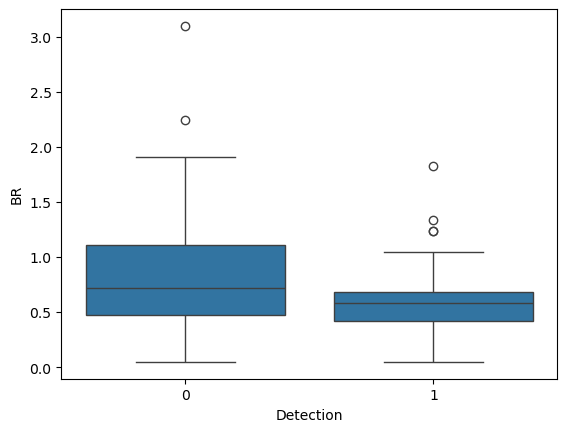

In [12]:
test_attr_detection_diff("BR", 0.5, [BR], [_B, _V])
# test_attr_event_diff("BR", 0.5, [BR], [_B, _V])


Detection stats for bleeding:
Detection
1    21
0     9
Name: count, dtype: int64
Detection stats for vomiting:
Detection
0    15
1    15
Name: count, dtype: int64
Correlation: 0.491
Mean for Detection 1: 9.361
Mean for Detection 0: 6.163
Normality test for Detection 1:  True
Normality test for Detection 0:  False
     U-val alternative     p-val      RBC      CLES
MWU  700.0   two-sided  0.000054 -0.62037  0.810185
Significant detected!


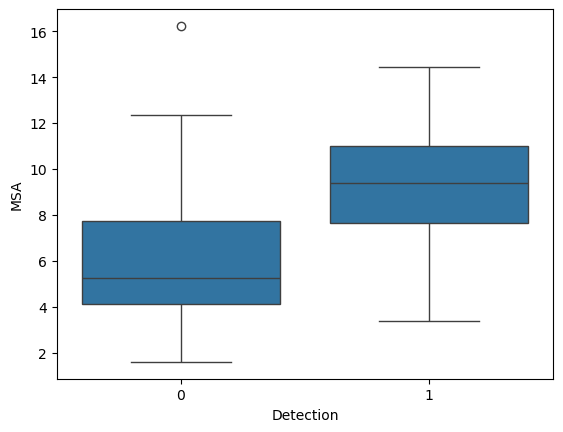

In [3]:
test_attr_detection_diff("MSA", 0.5, [BR], [_B, _V])
# test_attr_event_diff("MSA", 0.5, [BR], [_B, _V])

Detection stats for bleeding:
Detection
1    21
0     9
Name: count, dtype: int64
Detection stats for vomiting:
Detection
0    15
1    15
Name: count, dtype: int64
Correlation: -0.094
Mean for Detection 1: 1.628
Mean for Detection 0: 1.740
Normality test for Detection 1:  True
Normality test for Detection 0:  True
type 1 count:  36
type 2 count:  24
               T        dof alternative    p-val          CI95%   cohen-d  \
T-test -0.687767  42.457181   two-sided  0.49534  [-0.44, 0.21]  0.188798   

         BF10     power  
T-test  0.325  0.108534  
No significant difference detected.


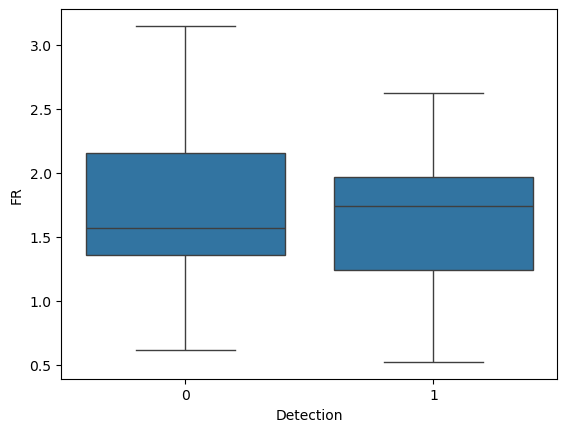

In [4]:
test_attr_detection_diff("FR", 0.5, [BR], [_B, _V])
# test_attr_event_diff("FR", 0.5, [BR], [_B, _V])

Detection stats for bleeding:
Detection
1    21
0     9
Name: count, dtype: int64
Detection stats for vomiting:
Detection
0    15
1    15
Name: count, dtype: int64
Correlation: 0.128
Mean for Detection 1: 0.563
Mean for Detection 0: 0.348
Normality test for Detection 1:  True
Normality test for Detection 0:  True
type 1 count:  36
type 2 count:  23
               T        dof alternative     p-val          CI95%   cohen-d  \
T-test  0.697791  53.829041   two-sided  0.488311  [-0.27, 0.55]  0.177602   

        BF10     power  
T-test  0.33  0.100286  
No significant difference detected.


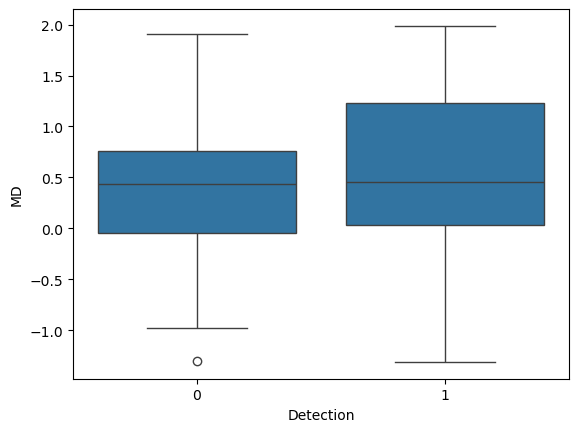

In [11]:
test_attr_detection_diff("MD", 0.5, [BR], [_B, _V])

Correlation: 0.060
Mean for Detection 1: 0.587
Mean for Detection 0: 0.545
Normality test for Detection 1:  False
Normality test for Detection 0:  False
     U-val alternative     p-val       RBC      CLES
MWU  473.0   two-sided  0.541123 -0.094907  0.547454
No significant difference detected.


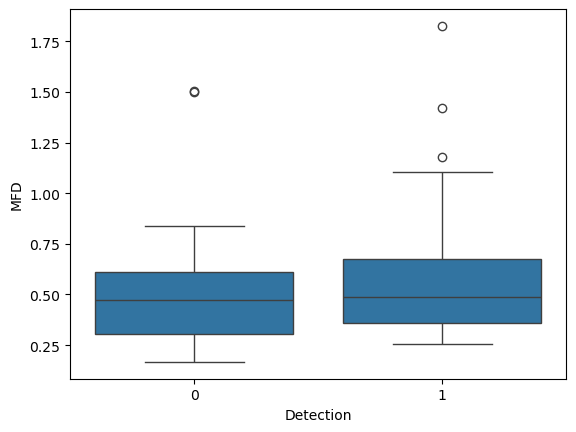

In [20]:
test_attr_detection_diff("MFD", 0.5, [BR], [_B, _V])

Correlation: 0.505
Mean for Detection 1: 196.522
Mean for Detection 0: 143.268
Normality test for Detection 1:  True
Normality test for Detection 0:  True
type 1 count:  35
type 2 count:  23
             T        dof alternative     p-val           CI95%   cohen-d  \
T-test  5.4977  43.565027   two-sided  0.000002  [38.94, 84.03]  1.509508   

             BF10     power  
T-test  1.336e+04  0.999818  
Significant detected!


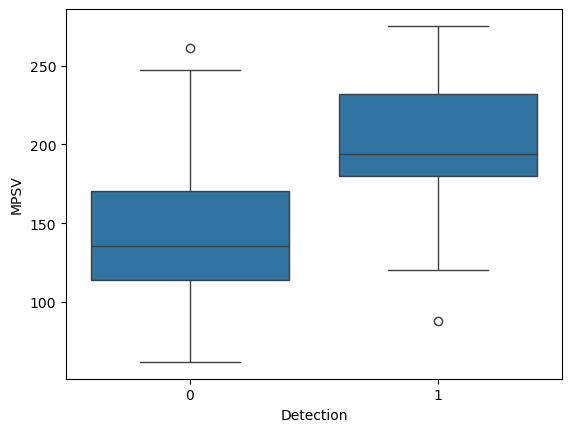

In [21]:
test_attr_detection_diff("MPSV", 0.5, [BR], [_B, _V])

Correlation: 0.483
Mean for Detection 1: 144.504
Mean for Detection 0: 111.792
Normality test for Detection 1:  True
Normality test for Detection 0:  True
type 1 count:  35
type 2 count:  24
               T        dof alternative     p-val           CI95%   cohen-d  \
T-test  4.350581  38.109882   two-sided  0.000098  [18.59, 50.93]  1.230795   

           BF10     power  
T-test  360.668  0.995401  
Significant detected!


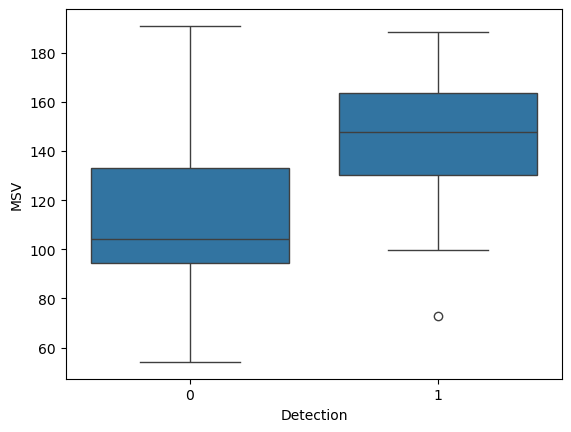

In [22]:
test_attr_detection_diff("MSV", 0.5, [BR], [_B, _V])

Correlation: 0.155
Mean for Detection 1: 0.792
Mean for Detection 0: 0.757
Normality test for Detection 1:  True
Normality test for Detection 0:  True
type 1 count:  36
type 2 count:  24
             T        dof alternative    p-val         CI95%   cohen-d  BF10  \
T-test  1.1197  38.890478   two-sided  0.26971  [-0.03, 0.1]  0.314224  0.45   

           power  
T-test  0.216433  
No significant difference detected.


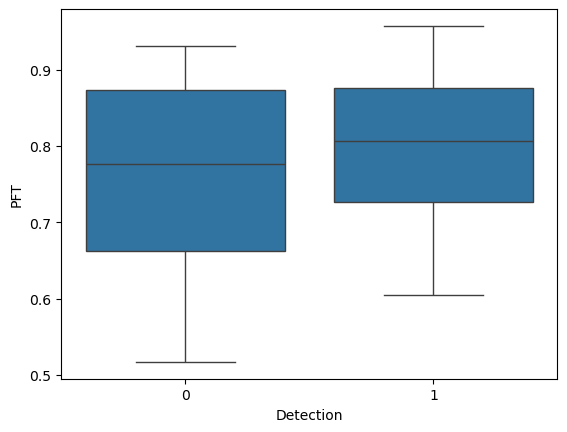

In [23]:
test_attr_detection_diff("PFT", 0.5, [BR], [_B, _V])

Correlation: 0.120
Mean for Detection 1: 0.729
Mean for Detection 0: 0.563
Normality test for Detection 1:  False
Normality test for Detection 0:  True
     U-val alternative     p-val       RBC      CLES
MWU  388.0   two-sided  0.511577  0.101852  0.449074
No significant difference detected.


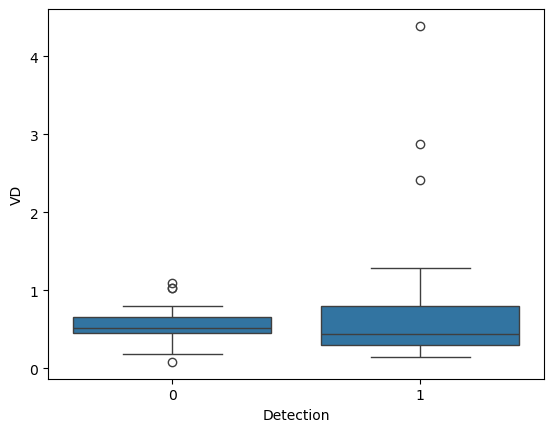

In [24]:
test_attr_detection_diff("VD", 0.5, [BR], [_B, _V])

Correlation: 0.188
Mean for Detection 1: 0.637
Mean for Detection 0: 0.508
Normality test for Detection 1:  True
Normality test for Detection 0:  False
     U-val alternative     p-val       RBC      CLES
MWU  556.0   two-sided  0.062315 -0.287037  0.643519
No significant difference detected.


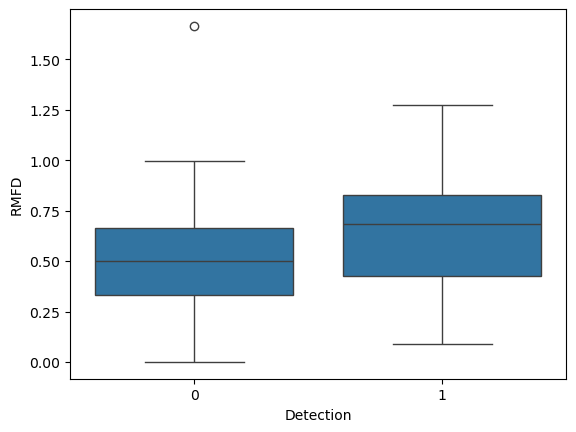

In [25]:
test_attr_detection_diff("RMFD", 0.5, [BR], [_B, _V])

Detection stats for bleeding:
Detection
1    21
0     9
Name: count, dtype: int64
Detection stats for vomiting:
Detection
0    15
1    15
Name: count, dtype: int64
Correlation: 0.426
Mean for Detection 1: 1.229
Mean for Detection 0: 1.051
Normality test for Detection 1:  True
Normality test for Detection 0:  False
     U-val alternative     p-val       RBC      CLES
MWU  701.0   two-sided  0.000051 -0.622685  0.811343
Significant detected!


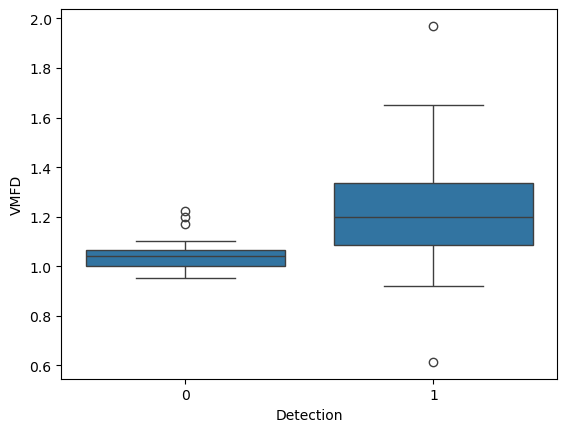

In [5]:
test_attr_detection_diff("VMFD", 0.5, [BR], [_B, _V])


Correlation: -0.538
Mean for Detection 1: 0.925
Mean for Detection 0: 1.539
Normality test for Detection 1:  True
Normality test for Detection 0:  True
type 1 count:  36
type 2 count:  24
               T        dof alternative     p-val          CI95%   cohen-d  \
T-test -4.371746  32.946072   two-sided  0.000116  [-0.9, -0.33]  1.279394   

           BF10     power  
T-test  391.364  0.997548  
Significant detected!


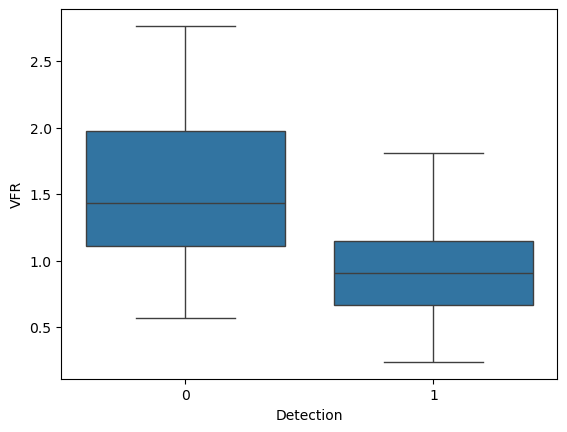

In [27]:
test_attr_detection_diff("VFR", 0.5, [BR], [_B, _V])
# test_attr_event_diff("VFR", 0.5, [BR], [_B, _V])


Correlation: 0.547
Mean for Detection 1: 0.703
Mean for Detection 0: 0.201
Normality test for Detection 1:  True
Normality test for Detection 0:  False
     U-val alternative     p-val       RBC      CLES
MWU  739.5   two-sided  0.000004 -0.711806  0.855903
Significant detected!


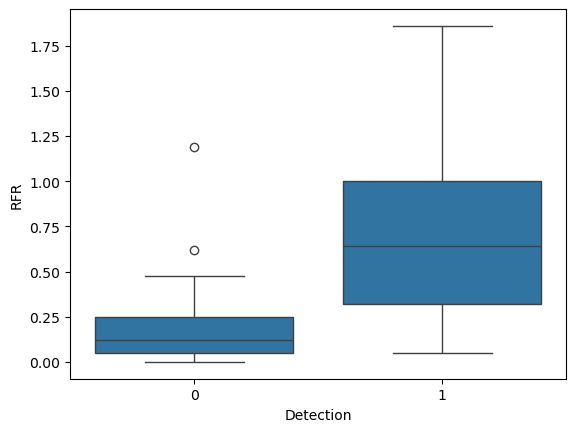

In [28]:
test_attr_detection_diff("RFR", 0.5, [BR], [_B, _V])
# the most likely to be different 

Correlation: 0.550
Mean for Detection 1: 0.291
Mean for Detection 0: 0.077
Normality test for Detection 1:  True
Normality test for Detection 0:  False
     U-val alternative     p-val       RBC      CLES
MWU  724.0   two-sided  0.000011 -0.675926  0.837963
Significant detected!


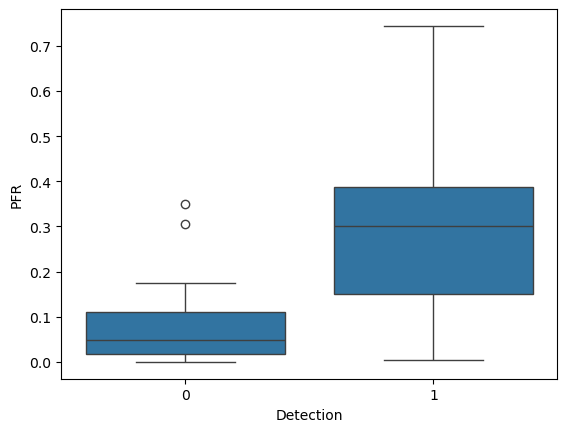

In [29]:
test_attr_detection_diff("PFR", 0.5, [BR], [_B, _V])


Correlation: -0.550
Mean for Detection 1: 0.709
Mean for Detection 0: 0.923
Normality test for Detection 1:  True
Normality test for Detection 0:  False
     U-val alternative     p-val       RBC      CLES
MWU  140.0   two-sided  0.000011  0.675926  0.162037
Significant detected!


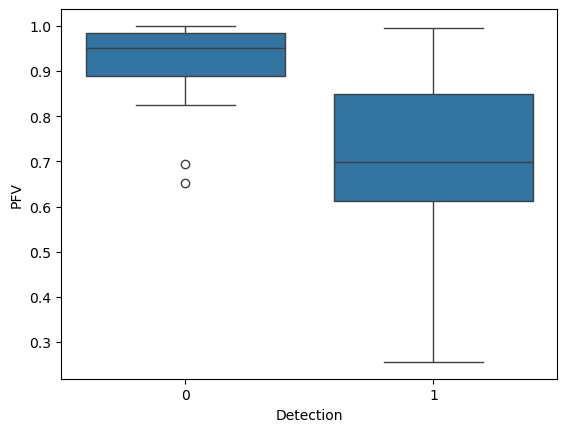

In [30]:
test_attr_detection_diff("PFV", 0.5, [BR], [_B, _V])
